# 1. Introduction

Name : Satriya Fauzan Adhim

Batch : RMT 019

Objective : The objective is to analyze and develop a robust and accurate sentiment expressed by customer review on the Trip Advisor Hotel Reviews and differentiate it either its negative or positive sentiment. This helps to understand the overall opinion and satisfaction of customers. The primary goal is to achieve high accuracy in the classification of sentiment. 

# ii. Import Libraries

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

# Split Dataset
import sklearn
from sklearn.model_selection import train_test_split

# Library Pre-Processing
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk import tokenize

# Library wordcloud
from wordcloud import WordCloud

# Library Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Activation, LSTM, GRU, TextVectorization, Embedding
from tensorflow.keras import Model 
import tensorflow_hub as hub

# Model Evaluation
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from collections import Counter

# model saving
import pickle
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

# iii. Data Loading

In [123]:
data = pd.read_csv("/content/drive/MyDrive/Phase 2/tripadvisor_hotel_reviews.csv")

data.head(5)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [124]:
data.tail(5)

,Review,Rating
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1
20490,"people talking, ca n't believe excellent ratin...",2


In [125]:
data.shape

(20491, 2)

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


# iv. Exploratory Data Analysis (EDA)

In [127]:
# Copying Dataset

df_eda = data.copy()

## 4.1 Checking Duplication Data

In [128]:
df_eda.duplicated().sum()

0

There are no duplicated data on dataset.

## 4.2 Checking Missing Value

In [129]:
df_eda.isnull().sum()

Review    0
Rating    0
dtype: int64

There're no missing values.

## 4.3 Rating Variable

Checking the column 'Rating' which is the target variable including the distribution of data.

In [130]:
df_eda['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

There are 5 Clasification on the rating. The classification gonna be grouped into 3 class, namely negative, neutral and positive, where 1 and 2 are negative, 3 are neutral, 4 and 5 are positive.

In [131]:
#  Rating = 1, 2 => Negative; 3 => Neutral;  4, 5 => Positive;
def ratings(rating):
    if rating in [1, 2, 3]:
        return "Negative"
    elif rating in [4, 5]:
        return "Positive"

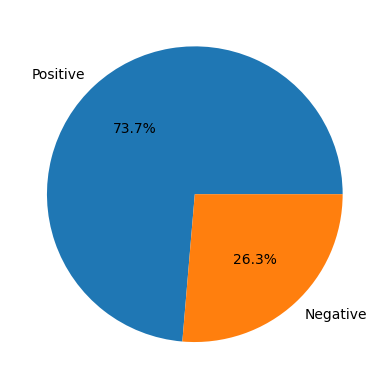

In [132]:
df_eda['Rating'] = df_eda['Rating'].apply(ratings)
plt.pie(df_eda['Rating'].value_counts(), labels=df_eda['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.show()

We can see that the distribution of data is imbalance, where the positive ratings is having a lot more data compared to  the negative ratings. Eventhough the positive one is higher, but the negative review is really important to be reviewed too.

## 4.4 Words Cloud

In [133]:
# Combining all review in one text
text_cloud = ' '.join(df_eda['Review'].dropna().tolist())

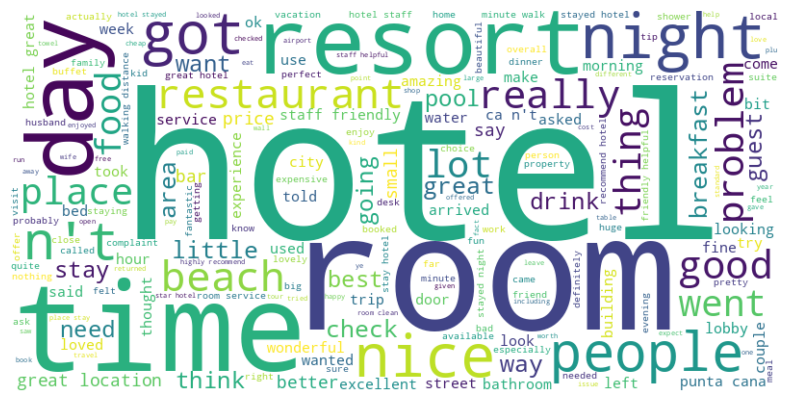

In [134]:
# Making the Workcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_cloud)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From the word cloud above we can know about the some of the word that are frequently used on the review. From there we can see the aspect that are getting mentioned a lot on the review like room, restaurant, breakfast etc. From the word cloud we can see too that a lot of positive word like good and nice. But from the word cloud alone we can't really see a lot of information and its just for a rough representation about the review data, so we need more detailed analysis about the data.

## 4.5 Counts and Lenght of the Review Data

In this we are gonna check the Character count, word count and the length of word and senctence on 'Review'

In [135]:
lenght = len(df_eda['Review'][0])
print(f'Length of a sample review: {lenght}')

Length of a sample review: 593


The length of review on first row of the data is 593.

In [136]:
df_eda['Length'] = df_eda['Review'].str.len()
df_eda.head(10)

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Positive,593
1,ok nothing special charge diamond member hilto...,Negative,1689
2,nice rooms not 4* experience hotel monaco seat...,Negative,1427
3,"unique, great stay, wonderful time hotel monac...",Positive,600
4,"great stay great stay, went seahawk game aweso...",Positive,1281
5,love monaco staff husband stayed hotel crazy w...,Positive,1002
6,"cozy stay rainy city, husband spent 7 nights m...",Positive,748
7,"excellent staff, housekeeping quality hotel ch...",Positive,597
8,"hotel stayed hotel monaco cruise, rooms genero...",Positive,419
9,excellent stayed hotel monaco past w/e delight...,Positive,271


### 4.5.1 Word Count

In [137]:
word_count = df_eda['Review'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

Word count in a sample review: 87


The length of review on first row of the data is 87 word.

In [138]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [139]:
df_eda['Word_count'] = df_eda['Review'].apply(word_count)
df_eda.head(10)

,Review,Rating,Length,Word_count
0,nice hotel expensive parking got good deal sta...,Positive,593,87
1,ok nothing special charge diamond member hilto...,Negative,1689,250
2,nice rooms not 4* experience hotel monaco seat...,Negative,1427,217
3,"unique, great stay, wonderful time hotel monac...",Positive,600,89
4,"great stay great stay, went seahawk game aweso...",Positive,1281,191
5,love monaco staff husband stayed hotel crazy w...,Positive,1002,134
6,"cozy stay rainy city, husband spent 7 nights m...",Positive,748,101
7,"excellent staff, housekeeping quality hotel ch...",Positive,597,85
8,"hotel stayed hotel monaco cruise, rooms genero...",Positive,419,59
9,excellent stayed hotel monaco past w/e delight...,Positive,271,35


### 4.5.2 Average Word length 

In [140]:
df_eda['mean_word_length'] = df_eda['Review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df_eda.head(10)

,Review,Rating,Length,Word_count,mean_word_length
0,nice hotel expensive parking got good deal sta...,Positive,593,87,5.804598
1,ok nothing special charge diamond member hilto...,Negative,1689,250,5.752000
2,nice rooms not 4* experience hotel monaco seat...,Negative,1427,217,5.571429
3,"unique, great stay, wonderful time hotel monac...",Positive,600,89,5.730337
4,"great stay great stay, went seahawk game aweso...",Positive,1281,191,5.701571
5,love monaco staff husband stayed hotel crazy w...,Positive,1002,134,6.470149
6,"cozy stay rainy city, husband spent 7 nights m...",Positive,748,101,6.396040
7,"excellent staff, housekeeping quality hotel ch...",Positive,597,85,6.011765
8,"hotel stayed hotel monaco cruise, rooms genero...",Positive,419,59,6.084746
9,excellent stayed hotel monaco past w/e delight...,Positive,271,35,6.714286


### 4.5.3 Average Sentence Length

In [141]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['Review'][0])])

591.0

In [142]:
df_eda['mean_sent_length'] = data['Review'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
df_eda.head(10)

,Review,Rating,Length,Word_count,mean_word_length,mean_sent_length
0,nice hotel expensive parking got good deal sta...,Positive,593,87,5.804598,591.0
1,ok nothing special charge diamond member hilto...,Negative,1689,250,5.752000,1687.0
2,nice rooms not 4* experience hotel monaco seat...,Negative,1427,217,5.571429,712.0
3,"unique, great stay, wonderful time hotel monac...",Positive,600,89,5.730337,598.0
4,"great stay great stay, went seahawk game aweso...",Positive,1281,191,5.701571,1279.0
5,love monaco staff husband stayed hotel crazy w...,Positive,1002,134,6.470149,1000.0
6,"cozy stay rainy city, husband spent 7 nights m...",Positive,748,101,6.396040,746.0
7,"excellent staff, housekeeping quality hotel ch...",Positive,597,85,6.011765,595.0
8,"hotel stayed hotel monaco cruise, rooms genero...",Positive,419,59,6.084746,417.0
9,excellent stayed hotel monaco past w/e delight...,Positive,271,35,6.714286,269.0


In [143]:
def visualize(col):
    plt.figure(figsize=(10, 6))
    for rating in df_eda['Rating'].unique():
        sns.kdeplot(df_eda[df_eda['Rating'] == rating][col], label=f'Rating {rating}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'KDE Plot for {col} with Different Ratings')
    plt.show()


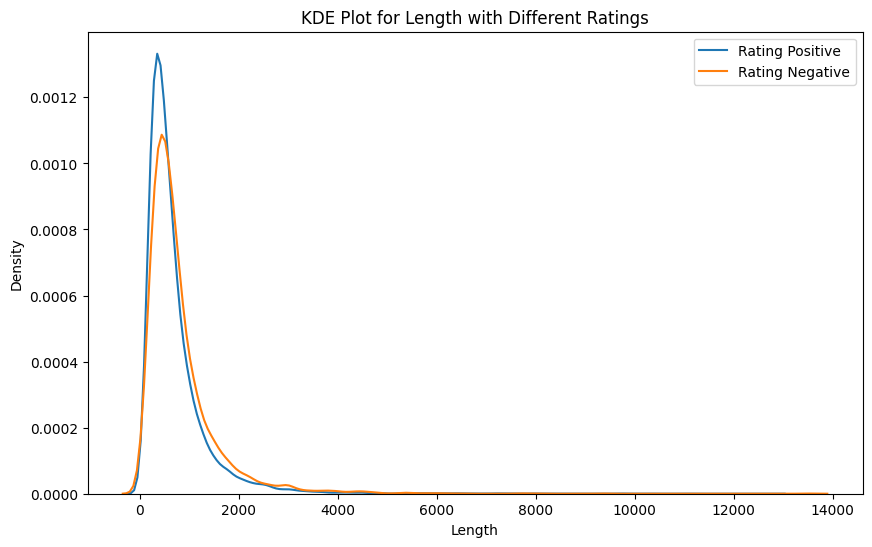

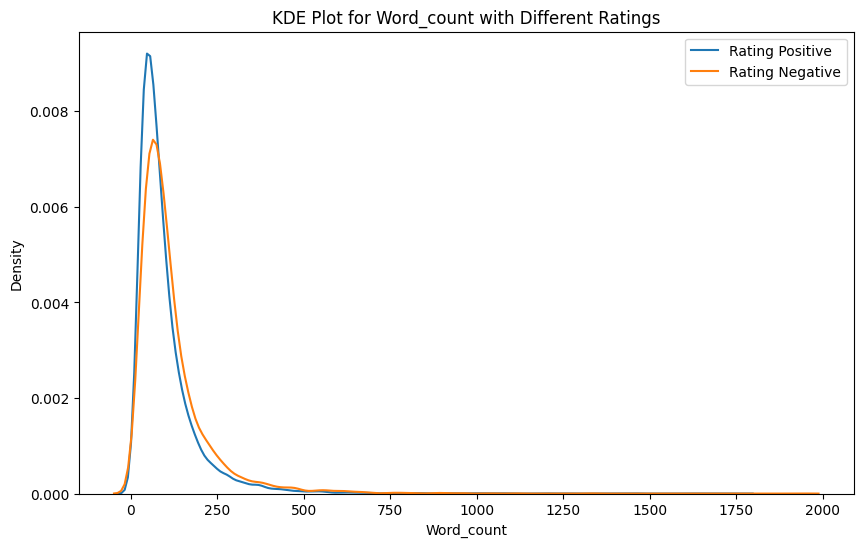

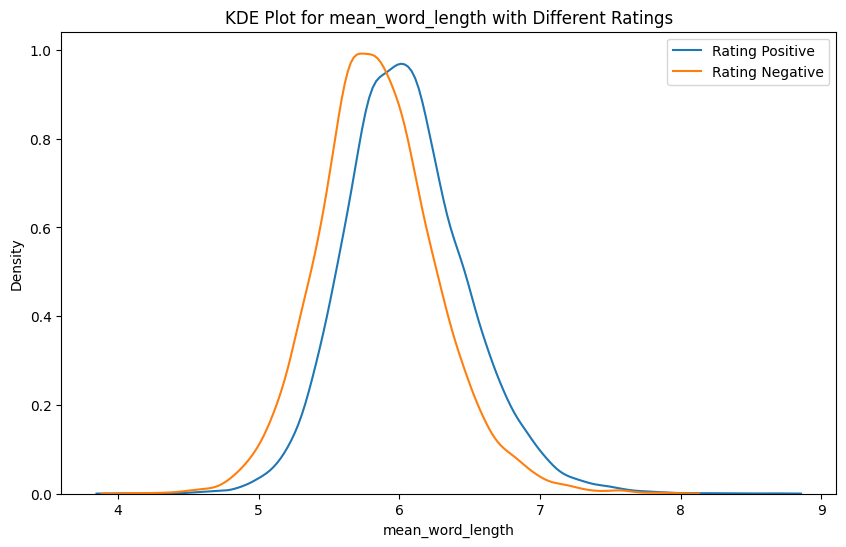

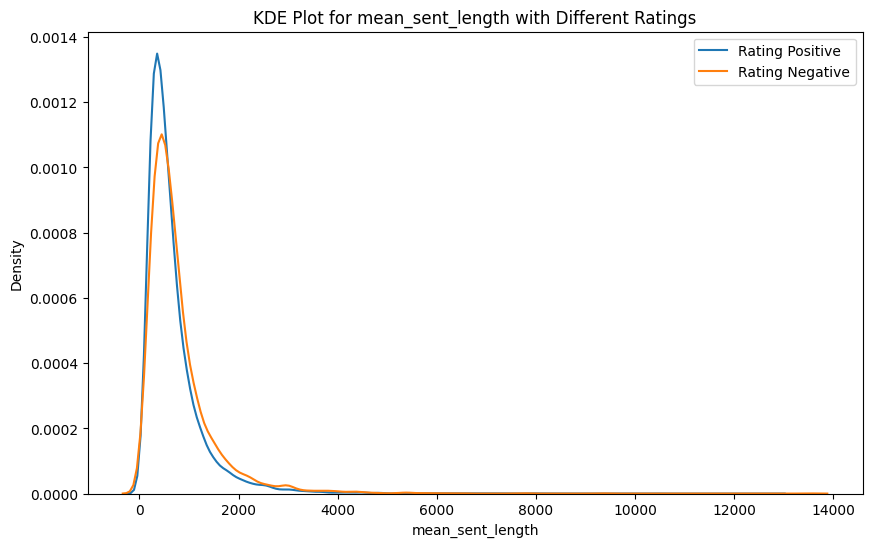

In [144]:
features = df_eda.columns.tolist()[2:]
for feature in features:
    visualize(feature)

## 4.6 Examples of positive, neutral and negative reviews

In [145]:
df_eda

,Review,Rating,Length,Word_count,mean_word_length,mean_sent_length
0,nice hotel expensive parking got good deal sta...,Positive,593,87,5.804598,591.0
1,ok nothing special charge diamond member hilto...,Negative,1689,250,5.752000,1687.0
2,nice rooms not 4* experience hotel monaco seat...,Negative,1427,217,5.571429,712.0
3,"unique, great stay, wonderful time hotel monac...",Positive,600,89,5.730337,598.0
4,"great stay great stay, went seahawk game aweso...",Positive,1281,191,5.701571,1279.0
...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",Positive,733,109,5.715596,731.0
20487,great location price view hotel great quick pl...,Positive,306,39,6.820513,304.0
20488,"ok just looks nice modern outside, desk staff ...",Negative,443,63,6.015873,441.0
20489,hotel theft ruined vacation hotel opened sept ...,Negative,5557,781,6.113956,5555.0


In [146]:

# Print sample reviews
pd.set_option('display.width', None)
sample_negative_review = df_eda[df_eda['Rating']=='Negative'].sample(20)
sample_positive_review = df_eda[df_eda['Rating']=='Positive'].sample(20)

# Print Sample of Negative Review
print('Example of Negative Reviews')
print('-'*100)
for review in sample_negative_review['Review']:
    print(review)
print('-' * 100)

# Print Sample of Positive Review
print('Example of Positive Reviews')
print('-'*100)
for review in sample_positive_review['Review']:
    print(review)
print('-' * 100)

Example of Negative Reviews
----------------------------------------------------------------------------------------------------
decent smiles wanted decent place stay san francisco, clean rooms, 10 mins walk fisherman wharf 5 mins cable car station union square, free parking, reasonable rates.best thing room large lcd t.v, n't seen hotels class/star-rating, desk personnel helpful informative, just wished smile talking, meant pleasant experience, word fisherman wharf.. authorities need homeless drunks roam place, incident scared drunk entered burger king restaurant young kids started harass couple eating table kids line counter, rush kids drunk began challenging 2 males fight, demanding given food, good thing thrown manager, geesh, way happened 7 pm,  
terrible overbooked hotel stay, staff wer not helpful, nearly no speaks english bare minimum nearly impossible point, room smelly mold bathroom toilet seat crooked, evening entertainment loud child trying sleep like sleeping stereo volum

Looking at the examples of various reviews from negative, neutral and positive reviews, we can distiguishes it like these:

1. Negative reviews: Generally expressing dissatisfaction and disappointments of the customers with the experience and service of the hotel. The topics that highlighted on here usually are the hotel service, hotel facilities and hotel condition. Negative reviews mainly use negative language on their reviews. 
2. Positive reviews: Generally expressing statisfaction with the experience of their hotel stays. The topics that highlighted on here usually are the good hotel service, nice hotel facilities and good price for the hotel. Positive reviews mainly use poisitive language on their reviews.

# v. Data Text Preproscessing

In [ ]:
# Copying Dataset

df =  data.copy()

In [ ]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

## 5.1 Text Preprocessing

Text preprocessing that we gonna do in this are:
1. Changing n't into not :

    From EDA, wordcloud and text sample we can see there are a lot of word "n't". Basically "n't" on text means word 'not' so we can change it to normalize the text.
2. Converting all text into lowercase :

    We want uniformity of the word on text, so there're no new classes for the words with uppercase letter.
3. Unicode removal :

    Removing unicode characters on text because of they're unreadable.
4. Punctuation and numbers removal (making text into letters only) :

    Making the text into letters only without any punctuation, symbols or numbers on the text. Basically it makes a normalization on the text so it can focus words meaning.
5. Whitespace removal :

    Removing whitespace on the text to improve efficiency, avoiding word confusion and incresing word connection. Whitespace removal example is just like removing whitespace on word 'ho tel' and transform it into 'hotel'.
6. Tokenizing words :

    Tokenizing meaning splitting sentence with spaces, example: "nice hotel expensive" into "nice", "hotel", "expensive".
7. Stopwords removal :

    Stopwords are words that are so common and frequently appear on the text and doesn't mean anything. By default, NLTK (Natural Language Toolkit) includes a list of 40 stop words, for example: “a”, “an”, “the”, “of”, “in”, etc. 
8. Lemmatization :

    Lemmatization needed to convert the words on text into the base or dictionary form. The example of lemmatization is transforming "got" into "get", "arrived" into "arrive". Lemmatization is needed for normalization of the words, vocabulary reduction and improving feature representation.

### 5.1.1 Transforming "n't"

In [ ]:
# Transforming "n't" into not
df['Review'] = df['Review'].str.replace("n't", "not")
df['Review'] = df['Review'].str.replace("nt", "not")

print(df['Review'][0])

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappoinoted non-existenot view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advanotage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  


### 5.1.2 Converting all text into lowercase

In [ ]:
text0 = df.Review[0]
text_lower = text0.lower()
text_lower

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappoinoted non-existenot view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advanotage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

### 5.1.3 Unicode removal

In [ ]:
# Removing Unicode Characters
text_code = re.sub(r'[^\x00-\x7F]', '', text_lower)
text_code

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappoinoted non-existenot view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advanotage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

### 5.1.4 Punctuation and numbers removal (making text into letters only)

In [ ]:
text_punc = text_code.translate(str.maketrans('', '', string.punctuation))
text_punc

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappoinoted nonexistenot view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advanotage staying longer location great walking distance shopping overall nice experience having pay 40 parking night  '

### 5.1.5 Whitespace removal

In [ ]:
teks_white = text_punc.strip()
teks_white

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappoinoted nonexistenot view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advanotage staying longer location great walking distance shopping overall nice experience having pay 40 parking night'

### 5.1.6 Tokenizing words 

In [ ]:
teks_token = word_tokenize(teks_white)
print(teks_token)

['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'did', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappoinoted', 'nonexistenot', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows', 'not', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway', 'maybe', 'just', 'noisy', 'neighbors', 'aveda', 'bath', 'products', 'nice', 'did', 'not', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advanotage', 'staying', 'longer', 'location', 'great', 'walking', 'distance', 'shopping', 'overall', 'nice', 'experience', 'having', 'pay', '40', 'parking', 'night']


### 5.1.7 Stopwords removal 

In [ ]:
stopwords = stopwords.words('english')

In [ ]:
text_stop = ' '.join([word for word in teks_token if word not in stopwords])
print(text_stop)

nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappoinoted nonexistenot view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advanotage staying longer location great walking distance shopping overall nice experience pay 40 parking night


### 5.1.8 Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

for word in text_stop.split():
    lem_word = lemmatizer.lemmatize(word, pos='v')  # Lemmatize verb
    lem_word = lemmatizer.lemmatize(lem_word, 'n')  # Lemmatize noun
    lem_word = lemmatizer.lemmatize(lem_word, 'a')  # Lemmatize adjective
    lem_word = lemmatizer.lemmatize(lem_word, 'r')  # Lemmatize adverb
    lem_word = lemmatizer.lemmatize(lem_word, 's')  # Lemmatize satellite adjectives
    sentence.append(lem_word)

text_lem = ' '.join(sentence)
print(text_lem)

nice hotel expensive park get good deal stay hotel anniversary, arrive late even take advice previous review do valet parking, check quick easy, little disappoint non-existent view room room clean nice size, bed comfortable wake stiff neck high pillows, not soundproof like hear music room night morning loud bang doors open close hear people talk hallway, maybe just noisy neighbors, aveda bath products nice, do not goldfish stay nice touch take advantage stay longer, location great walk distance shopping, overall nice experience have pay 40 park night, nice hotel expensive park get good deal stay hotel anniversary arrive late even take advice previous review valet park check quick easy little disappoinoted nonexistenot view room room clean nice size bed comfortable wake stiff neck high pillow soundproof like hear music room night morning loud bang door open close hear people talk hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch take advanotage stay long loca

We used lemmatization on all Parts of Speech to helps reduce the variation of words with different forms, hoping to improve the model's ability to recognize semantically similar words.

### 5.1.9 Preprocessing on all documents

We compile all the codes for text preprocessing above into one function to be used to preprocess all documents.

In [ ]:
lemmatizer = WordNetLemmatizer()
def text_processing(text):

    # Converting all text to Lowercase
    text = text.lower()

    # Removing Unicode Characters
    text = re.sub(r'[^\x00-\x7F]', '', text)

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("[^A-Za-z\s']", " ", text)
  
    # Menghilangkan \n
    text = re.sub(r"\\n", " ", text)

    # Removing Whitespace
    text = text.strip()

    # Removing double space
    text = re.sub("\s\s+" , " ", text)
        
    # Tokenizing words
    tokens = word_tokenize(text)

    # Removing Stopwords
    text = ' '.join([word for word in tokens if word not in stopwords])

    # Lemmatizer
    sentence = []
    for word in text.split():
        lem_word = lemmatizer.lemmatize(word, pos='v')  # Lemmatize verb
        lem_word = lemmatizer.lemmatize(lem_word, 'n')  # Lemmatize noun
        sentence.append(lem_word)
    
    text = ' '.join(sentence)

    return text

In [ ]:
# Applying the preprocessing text
df['Review_processed'] = df['Review'].apply(lambda x: text_processing(x))
df = df.reset_index()
df = df.drop(['index'],axis=1)
df

,Review,Rating,Review_processed
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, wenot seahawk game awes...",5,great stay great stay wenot seahawk game aweso...
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best keep secret rd time stay charm star ca be...
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outside desk staff particu...
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruin vacation hotel open sept gues...


## 5.2 Split between Train-Set, Val-Set, and Test-Set

In [ ]:
# Melihat Persebaran Target

df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
# Split between Train-Set, Val-Set, and Test-Set

X_train_val, X_test, y_train_val, y_test = train_test_split(df['Review_processed'], df['Rating'], test_size=0.15, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=10)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)
print('Test Size : ', X_test.shape)

Train Size :  (14804,)
Val Size :  (2613,)
Test Size :  (3074,)


In [ ]:
# copy X_test
X_test_copy = X_test.copy()

## 5.3 Tokenization

Tokenization is one of important step on NLP. It allows for further analysis of the individual tokens, such as part-of-speech tagging, named entity recognition, and sentiment analysis. It also helps with text normalization and cleaning, by removing unwanted characters and formatting from the text.

In [ ]:
# Tokenazing the Data (the Reviews)

t = Tokenizer(oov_token='') # Unknown

# fit the tokenizer on train documents
t.fit_on_texts(X_train)

In [ ]:
# Get our training data word index
word_index = t.word_index

# Finding number of vocabularies and length of token in one document
sum_vocab = len(word_index)
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Number of Vocabularies : ", sum_vocab)
print("Maximum review length in words : ", max_sen_len, "words")

Number of Vocabularies :  54015
Maximum review length in words :  1835 words


There are 54015 vocabularies on the data. The longest review on data are review with 1835 words.

In [152]:
# top 1000 token
word_index

{'': 1,
 'hotel': 2,
 'room': 3,
 'stay': 4,
 'great': 5,
 'good': 6,
 'staff': 7,
 'night': 8,
 'day': 9,
 'time': 10,
 'nice': 11,
 'location': 12,
 'clean': 13,
 'service': 14,
 'walk': 15,
 'beach': 16,
 'breakfast': 17,
 'place': 18,
 'like': 19,
 'food': 20,
 'resort': 21,
 'get': 22,
 'pool': 23,
 'bed': 24,
 'really': 25,
 'area': 26,
 'say': 27,
 'book': 28,
 'friendly': 29,
 'people': 30,
 'small': 31,
 'bar': 32,
 'little': 33,
 'recommend': 34,
 'excellenot': 35,
 'bathroom': 36,
 'look': 37,
 'view': 38,
 'best': 39,
 'minute': 40,
 'make': 41,
 'helpful': 42,
 'price': 43,
 'trip': 44,
 'floor': 45,
 'restauranot': 46,
 'use': 47,
 'lot': 48,
 'need': 49,
 'come': 50,
 'water': 51,
 'think': 52,
 'check': 53,
 'take': 54,
 'restauranots': 55,
 'drink': 56,
 'review': 57,
 'beautiful': 58,
 'leave': 59,
 'eat': 60,
 'ask': 61,
 'wenot': 62,
 'thing': 63,
 'try': 64,
 'return': 65,
 'comfortable': 66,
 'desk': 67,
 'love': 68,
 'problem': 69,
 'right': 70,
 'way': 71,
 'go'

In [ ]:
# Transforming Reviews to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

In [ ]:
# Padding the dataset to a maximum review length in words

X_train = pad_sequences(X_train, maxlen=max_sen_len)
X_test = pad_sequences(X_test, maxlen=max_sen_len)
X_val = pad_sequences(X_val, maxlen=max_sen_len)

In [ ]:
# Document Example
print('Sample')
print(df.Review[0])
print('')

# Padding Results
print('Padding Results')
print(X_train[0])
print('Size : ', X_train[0].shape)

Sample
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappoinoted non-existenot view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advanotage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Padding Results
[  0   0   0 ...  18 271 236]
Size :  (1835,)


## 5.4 Encoding

This section explains the process of encoding with LabelEncoder. LabelEncoder is used to change the label to 0 for negative reviews where the ratings are 1,2 and 3; and 1 for positive reviews where ratings are 4 and 5. We only need to do the encoding only on data target.

In [ ]:
#  LabelEncoder Initiation
le = LabelEncoder()

# Mapping class
class_mapping = {
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1
}

# Mapping class on target
y_train = le.fit_transform(y_train.map(class_mapping))
y_test = le.transform(y_test.map(class_mapping))
y_val = le.transform(y_val.map(class_mapping))

## 5.5 Pipeline for Tensorflow

In [ ]:
# Bundle preprocessing for numerical and categorical data to tensorflow before being input to the model
train_pipe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(1024).shuffle(len(X_train)).prefetch(tf.data.AUTOTUNE)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(1024)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(1024)

# 6. Model Definition

The algorithms that are used on this modelling are LSTM and GRU. These two model gonna be improved and the one which performed better gonna be chosen. Accuracy is used as the metric of evaluation on this modelling, because with high accuracy it can indicates that the model is able to correctly classify the sentiment that are expressed on the reviews, from that sentiment it can be used to make decision regarding business strategies.

## 6.1 LSTM Base Model 

Hyperparameters that are used on this base model are:
 - Number of neuron that used on the models are 32 neurons.
 - Numbers of hidden layer that gonna be used on this base model are 2 hidden layers. We use 2 hidden layers because of the data less complex and the dimension of features is few.
 - Using Sequential API to make the baseline model simple.
 - Using SGD as optimizer.

In [ ]:
# Clear Session

seed = 69
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# model initialization
model = Sequential()


# The Embedding Layer
model.add(Embedding(input_dim=sum_vocab, output_dim=128,embeddings_initializer="uniform", input_length=max_sen_len))

# The LSTM layer (32)
model.add(LSTM(32,return_sequences=True))

# The LSTM layer (8)
model.add(LSTM(8))

# The Classification layer
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='BinaryCrossentropy',
              optimizer='SGD', 
              metrics='accuracy')

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1835, 128)         6913920   
                                                                 
 lstm (LSTM)                 (None, 1835, 32)          20608     
                                                                 
 lstm_1 (LSTM)               (None, 8)                 1312      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,935,849
Trainable params: 6,935,849
Non-trainable params: 0
_________________________________________________________________


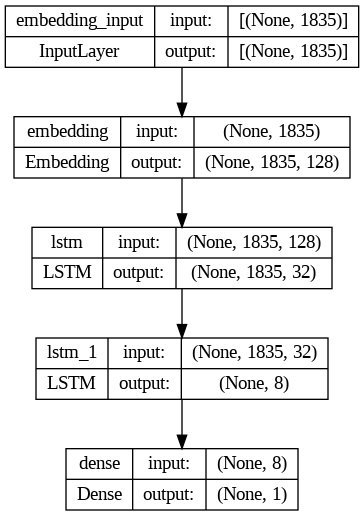

In [ ]:
# Plot Layers
tf.keras.utils.plot_model(model, show_shapes=True)

## 6.2 LSTM Improved Model 

The hyperparameters of the model is modified in this to get better result. Hyperparameters that being modified are :
- Using dropout to all hidden layers for early stopping to prevent overfitting
- Using Adam as optimizer
- Adding Bidirectional LSTM layer, BiLSTM said to be a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

In [ ]:
# Clear Session

seed = 69
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# model improvement initialization
model_imp = Sequential()

# The Embedding Layer
model_imp.add(Embedding(input_dim=sum_vocab, output_dim=128,embeddings_initializer="uniform", input_length=max_sen_len))

# The LSTM layer (32)
model_imp.add(tf.keras.layers.Bidirectional(LSTM(32,return_sequences=True)))

# The LSTM layer (8)
model_imp.add(LSTM(8))

# Dropout Layer
model_imp.add(Dropout(0.2))

# The Classification layer
model_imp.add(Dense(1, activation='sigmoid'))

# compile model_imp
model_imp.compile(loss='BinaryCrossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

# model_imp summary
model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1835, 128)         6913920   
                                                                 
 bidirectional (Bidirectiona  (None, 1835, 64)         41216     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 8)                 2336      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,957,481
Trainable params: 6,957,481
Non-trainable params: 0
______________________________________________

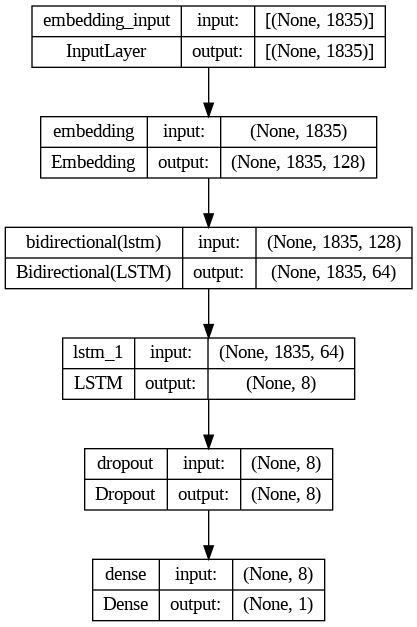

In [ ]:
# Plot Layers
tf.keras.utils.plot_model(model_imp, show_shapes=True)

## 6.3 GRU Baseline Model

Hyperparameter that used on this base model is gonna be the same as the LSTM base model before.
 - Number of neuron that used on the models are 32 neurons.
 - Numbers of hidden layer that gonna be used on this base model are 2 hidden layers. We use 2 hidden layers because of the data less complex and the dimension of features is few.
 - Using Sequential API to make the baseline model simple.
 - Using SGD as optimizer.

In [ ]:
# Clear Session

seed = 69
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# model initialization
model_gru = Sequential()

# The Embedding Layer
model_gru.add(Embedding(input_dim=sum_vocab, output_dim=128,embeddings_initializer="uniform", input_length=max_sen_len))

# The GRU layer (32)
model_gru.add(GRU(32,return_sequences=True))

# The GRU layer (8)
model_gru.add(GRU(8))

# The Classification layer
model_gru.add(Dense(1, activation='sigmoid'))

# compile model_gru
model_gru.compile(loss='BinaryCrossentropy',
              optimizer='SGD', 
              metrics='accuracy')

# model_gru summary
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1835, 128)         6913920   
                                                                 
 gru (GRU)                   (None, 1835, 32)          15552     
                                                                 
 gru_1 (GRU)                 (None, 8)                 1008      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,930,489
Trainable params: 6,930,489
Non-trainable params: 0
_________________________________________________________________


## 6.4 GRU Improvement Model

The hyperparameters of the model is modified in this to get better result. Hyperparameters that being modified are :
- Using dropout to all hidden layers for early stopping to prevent overfitting
- Using Adam as optimizer
- Adding Bidirectional layer, it said to be a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

In [ ]:
# Clear Session

seed = 69
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# model improvement initialization
model_gruimp = Sequential()

# The Embedding Layer
model_gruimp.add(Embedding(input_dim=sum_vocab, output_dim=128,embeddings_initializer="uniform", input_length=max_sen_len))

# The GRU layer (32)
model_gruimp.add(tf.keras.layers.Bidirectional(GRU(32,return_sequences=True)))

# The GRU layer (8)
model_gruimp.add(GRU(8))

# Dropout Layer
model_gruimp.add(Dropout(0.2))

# The Classification layer
model_gruimp.add(Dense(1, activation='sigmoid'))

# compile model_gruimp
model_gruimp.compile(loss='BinaryCrossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

# model_gruimp summary
model_gruimp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1835, 128)         6913920   
                                                                 
 bidirectional (Bidirectiona  (None, 1835, 64)         31104     
 l)                                                              
                                                                 
 gru_1 (GRU)                 (None, 8)                 1776      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,946,809
Trainable params: 6,946,809
Non-trainable params: 0
______________________________________________

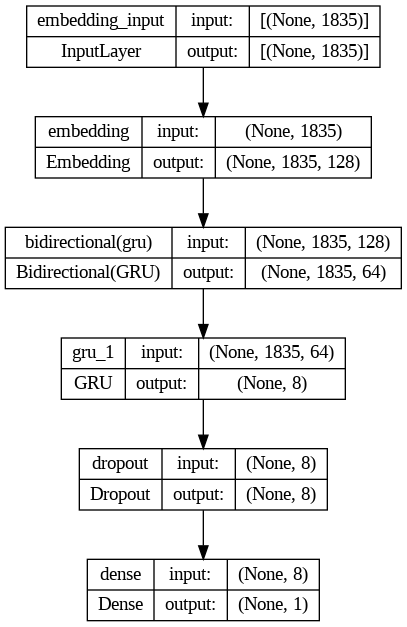

In [ ]:
# Plot Layers
tf.keras.utils.plot_model(model_gruimp, show_shapes=True)

# vii. Model Training

## 7.1 LSTM Base Model

In [ ]:
%%time
history1 = model.fit(train_pipe,validation_data=(val_pipe), epochs=50)

Epoch 1/50
15/15 [==============================] - 9s 311ms/step - loss: 0.6753 - accuracy: 0.7166 - val_loss: 0.6569 - val_accuracy: 0.7390
Epoch 2/50
15/15 [==============================] - 4s 265ms/step - loss: 0.6460 - accuracy: 0.7375 - val_loss: 0.6340 - val_accuracy: 0.7390
Epoch 3/50
15/15 [==============================] - 4s 258ms/step - loss: 0.6270 - accuracy: 0.7375 - val_loss: 0.6187 - val_accuracy: 0.7390
Epoch 4/50
15/15 [==============================] - 4s 259ms/step - loss: 0.6143 - accuracy: 0.7375 - val_loss: 0.6078 - val_accuracy: 0.7390
Epoch 5/50
15/15 [==============================] - 4s 266ms/step - loss: 0.6050 - accuracy: 0.7375 - val_loss: 0.5999 - val_accuracy: 0.7390
Epoch 6/50
15/15 [==============================] - 4s 260ms/step - loss: 0.5981 - accuracy: 0.7375 - val_loss: 0.5940 - val_accuracy: 0.7390
Epoch 7/50
15/15 [==============================] - 4s 260ms/step - loss: 0.5930 - accuracy: 0.7375 - val_loss: 0.5896 - val_accuracy: 0.7390
Epoch 

## 7.2 LSTM Improvement Model

In [ ]:
%%time
history2 = model_imp.fit(train_pipe,validation_data=(val_pipe), epochs=50)

Epoch 1/50
15/15 [==============================] - 15s 655ms/step - loss: 0.6867 - accuracy: 0.6795 - val_loss: 0.6794 - val_accuracy: 0.7390
Epoch 2/50
15/15 [==============================] - 8s 519ms/step - loss: 0.6728 - accuracy: 0.7368 - val_loss: 0.6647 - val_accuracy: 0.7390
Epoch 3/50
15/15 [==============================] - 8s 512ms/step - loss: 0.6564 - accuracy: 0.7376 - val_loss: 0.6463 - val_accuracy: 0.7390
Epoch 4/50
15/15 [==============================] - 8s 522ms/step - loss: 0.6351 - accuracy: 0.7374 - val_loss: 0.6234 - val_accuracy: 0.7390
Epoch 5/50
15/15 [==============================] - 8s 509ms/step - loss: 0.6113 - accuracy: 0.7374 - val_loss: 0.5982 - val_accuracy: 0.7390
Epoch 6/50
15/15 [==============================] - 8s 507ms/step - loss: 0.5871 - accuracy: 0.7374 - val_loss: 0.5743 - val_accuracy: 0.7390
Epoch 7/50
15/15 [==============================] - 8s 520ms/step - loss: 0.5652 - accuracy: 0.7375 - val_loss: 0.5561 - val_accuracy: 0.7390
Epoch

## 7.3 GRU Base Model

In [ ]:
%%time
history3 = model_gru.fit(train_pipe,validation_data=(val_pipe), epochs=50)

Epoch 1/50
15/15 [==============================] - 8s 340ms/step - loss: 0.6702 - accuracy: 0.7027 - val_loss: 0.6457 - val_accuracy: 0.7390
Epoch 2/50
15/15 [==============================] - 4s 265ms/step - loss: 0.6317 - accuracy: 0.7375 - val_loss: 0.6175 - val_accuracy: 0.7390
Epoch 3/50
15/15 [==============================] - 4s 271ms/step - loss: 0.6099 - accuracy: 0.7375 - val_loss: 0.6007 - val_accuracy: 0.7390
Epoch 4/50
15/15 [==============================] - 4s 266ms/step - loss: 0.5966 - accuracy: 0.7375 - val_loss: 0.5906 - val_accuracy: 0.7390
Epoch 5/50
15/15 [==============================] - 4s 267ms/step - loss: 0.5886 - accuracy: 0.7375 - val_loss: 0.5844 - val_accuracy: 0.7390
Epoch 6/50
15/15 [==============================] - 4s 276ms/step - loss: 0.5837 - accuracy: 0.7375 - val_loss: 0.5805 - val_accuracy: 0.7390
Epoch 7/50
15/15 [==============================] - 4s 272ms/step - loss: 0.5806 - accuracy: 0.7375 - val_loss: 0.5781 - val_accuracy: 0.7390
Epoch 

## 7.4 GRU Improvement Model

In [ ]:
%%time
history4 = model_gruimp.fit(train_pipe,validation_data=(val_pipe), epochs=50)

Epoch 1/50
15/15 [==============================] - 16s 605ms/step - loss: 0.6876 - accuracy: 0.6358 - val_loss: 0.6808 - val_accuracy: 0.7340
Epoch 2/50
15/15 [==============================] - 8s 498ms/step - loss: 0.6744 - accuracy: 0.7365 - val_loss: 0.6681 - val_accuracy: 0.7390
Epoch 3/50
15/15 [==============================] - 8s 498ms/step - loss: 0.6607 - accuracy: 0.7379 - val_loss: 0.6545 - val_accuracy: 0.7390
Epoch 4/50
15/15 [==============================] - 8s 504ms/step - loss: 0.6455 - accuracy: 0.7375 - val_loss: 0.6397 - val_accuracy: 0.7390
Epoch 5/50
15/15 [==============================] - 8s 497ms/step - loss: 0.6299 - accuracy: 0.7375 - val_loss: 0.6235 - val_accuracy: 0.7390
Epoch 6/50
15/15 [==============================] - 8s 500ms/step - loss: 0.6114 - accuracy: 0.7375 - val_loss: 0.6062 - val_accuracy: 0.7390
Epoch 7/50
15/15 [==============================] - 8s 508ms/step - loss: 0.5935 - accuracy: 0.7375 - val_loss: 0.5887 - val_accuracy: 0.7390
Epoch

# viii. Model Evaluation

Evaluating the model that already made and trained above.

## 8.1 LSTM Base Model


### Training Set


Dataframe made from the training model.

In [ ]:
# Create DataFrame

history1_df = pd.DataFrame(history1.history)
history1_df.tail(5)

,loss,accuracy,val_loss,val_accuracy
45,0.575562,0.737503,0.574039,0.738997
46,0.575556,0.737503,0.574034,0.738997
47,0.575552,0.737503,0.574030,0.738997
48,0.575547,0.737503,0.574025,0.738997
49,0.575540,0.737503,0.574022,0.738997


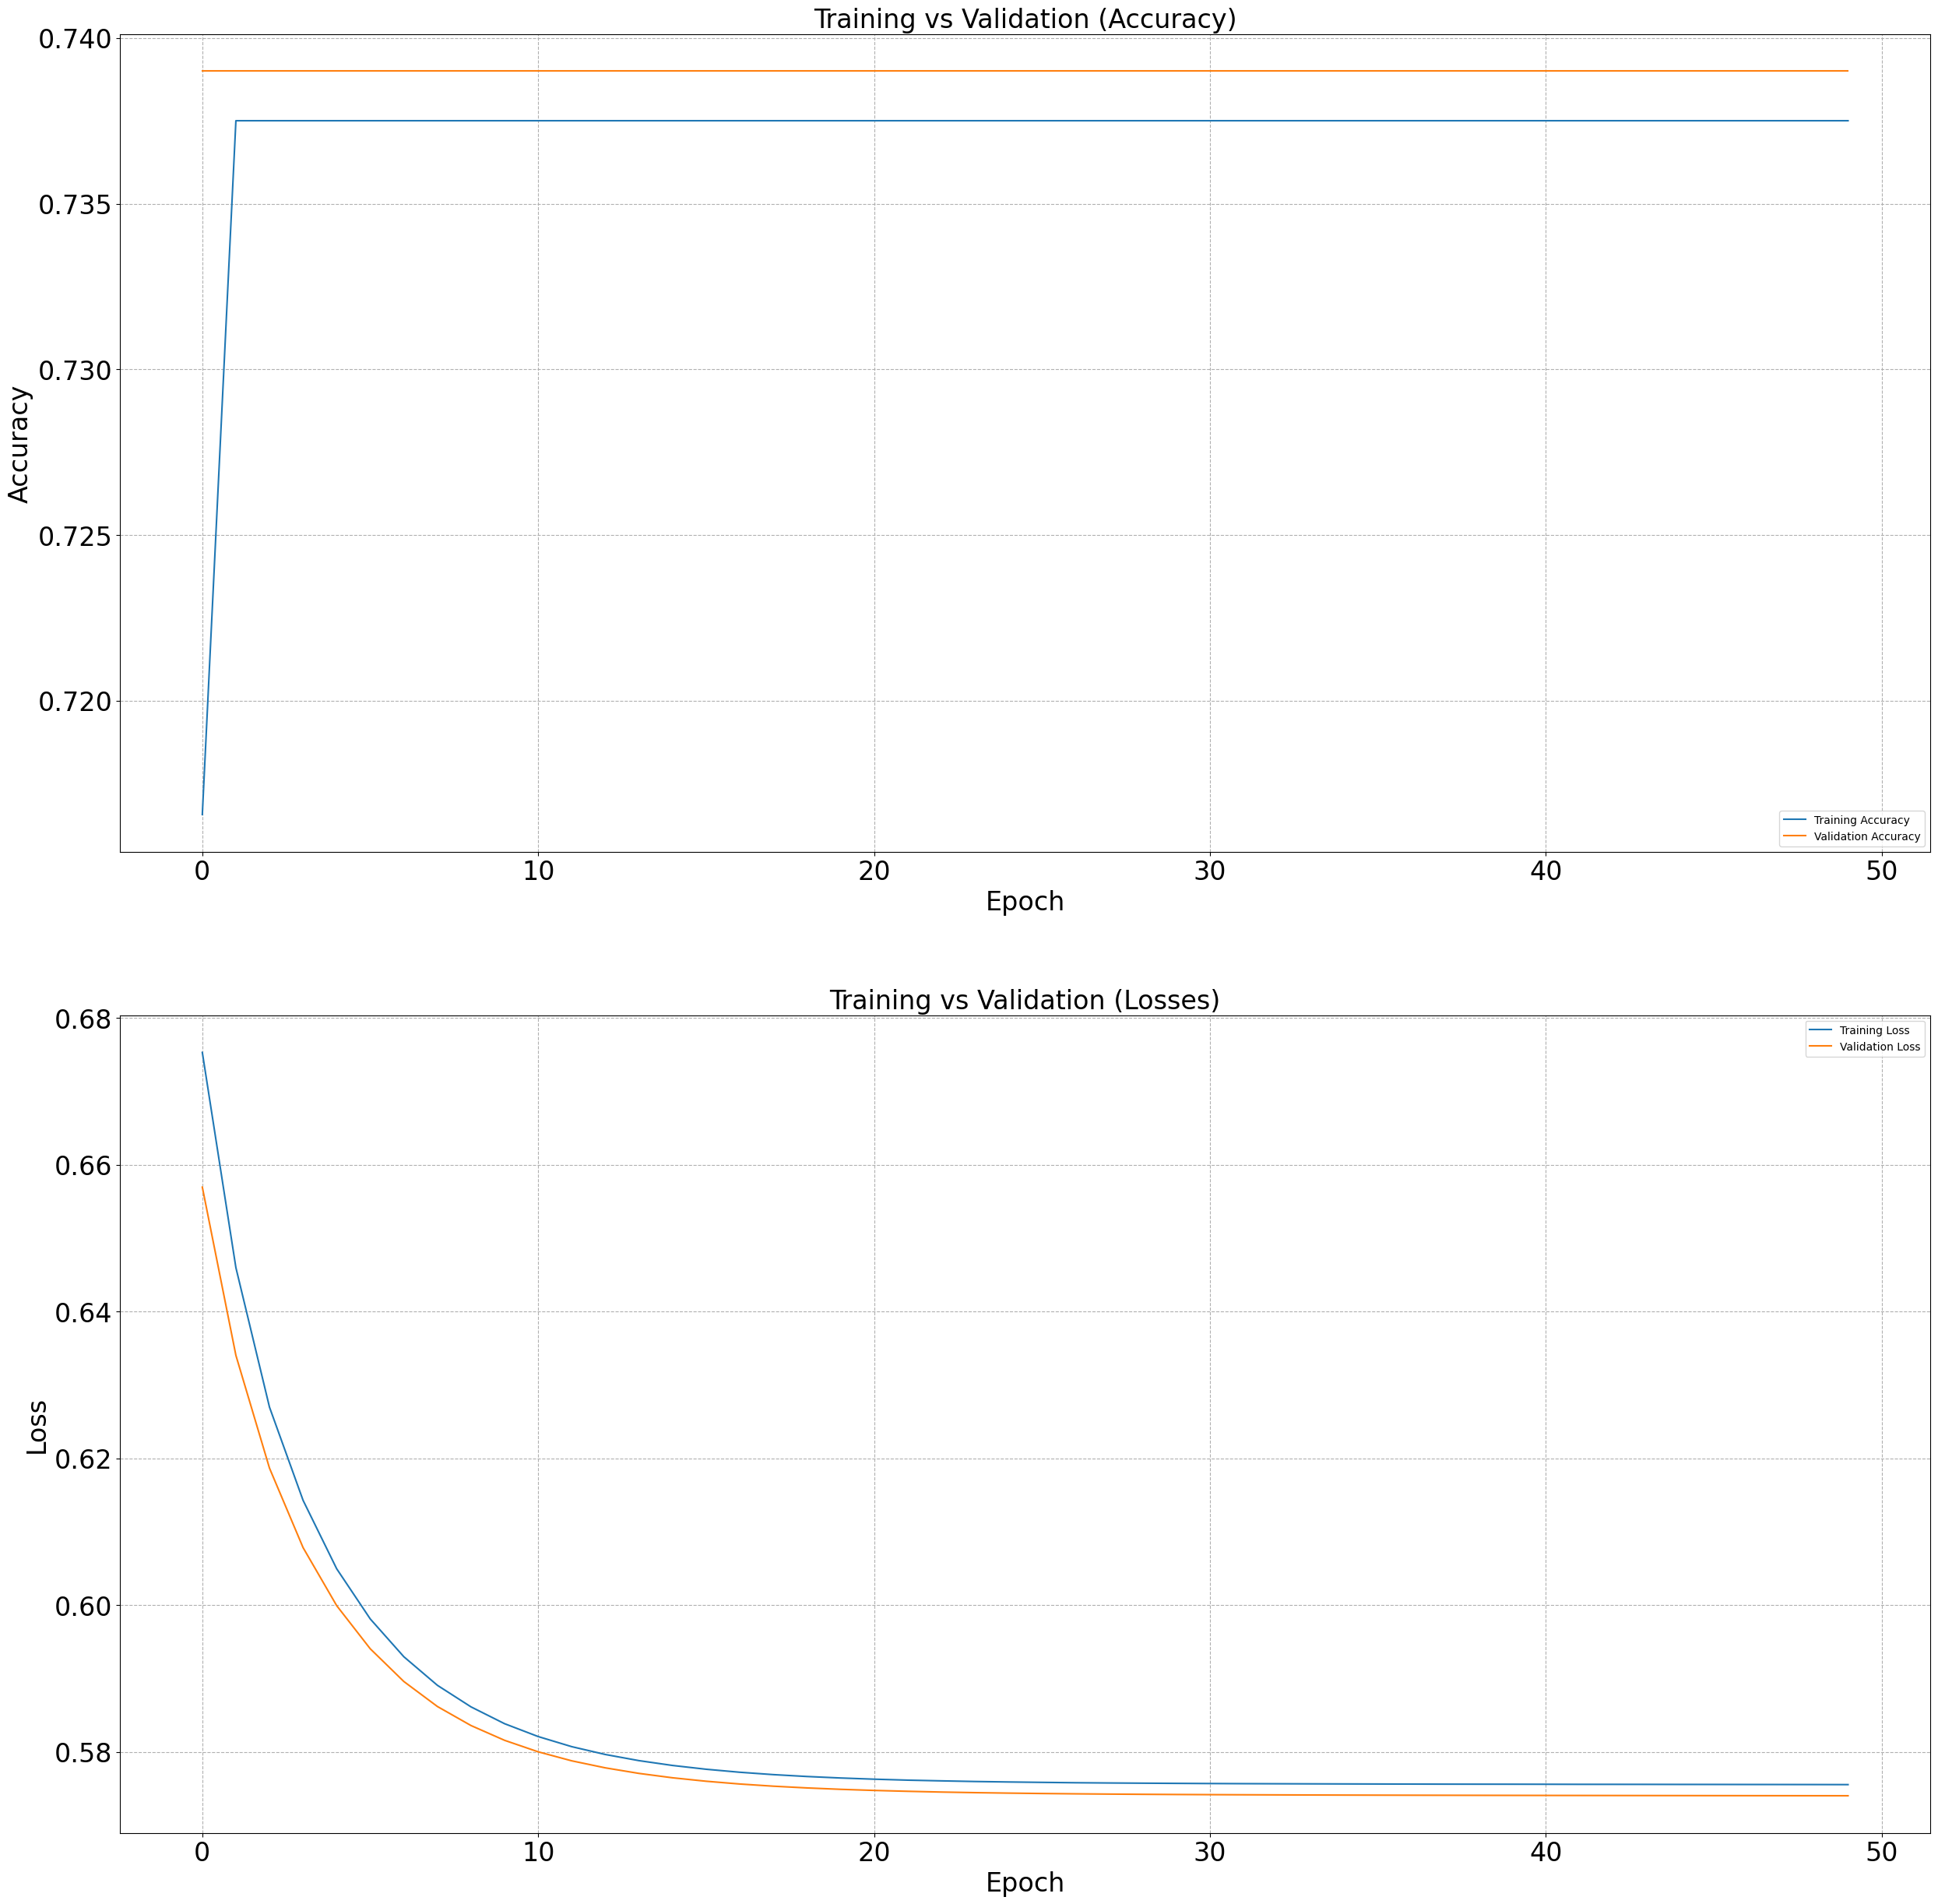

In [ ]:
# Training Data Evaluation
fig, ax = plt.subplots(2,1, figsize=(30,30))

# fig.suptitle('Training Data Evaluation', fontsize=50, weight='bold')

plt.subplot(2,1,1)
plt.title("Training vs Validation (Accuracy)", fontsize=24)
plt.plot(history1.history['accuracy'],label="Training Accuracy")
plt.plot(history1.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(2,1,2)
plt.title("Training vs Validation (Losses)", fontsize=24)
plt.plot(history1.history['loss'], label="Training Loss")
plt.plot(history1.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Loss", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

### Test Set

97/97 [==============================] - 4s 38ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       830
           1       0.73      1.00      0.84      2244

    accuracy                           0.73      3074
   macro avg       0.36      0.50      0.42      3074
weighted avg       0.53      0.73      0.62      3074



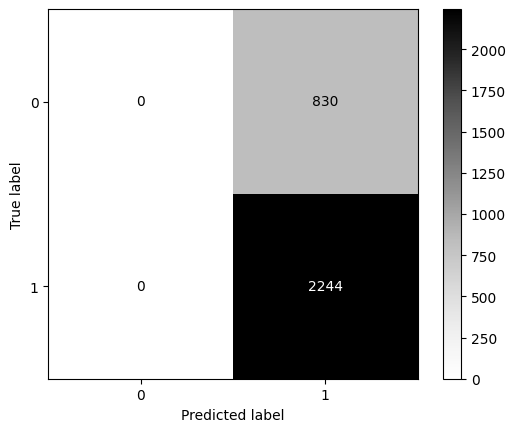

In [ ]:
# Model Evaluation of test-set

y_pred_1 = model.predict(X_test)
y_pred_1 = np.where(y_pred_1 >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_1))

# confusion matrix

cm = confusion_matrix(y_test, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Greys')
plt.show()

It can be seen on the Classification report above, it shows that the model is not really good with the evaluation metrics really low, but we are gonna do some improvement from this baseline model.

## 8.2 LSTM Improvement Model


### Training Set


In [ ]:
# Create DataFrame

history2_df = pd.DataFrame(history2.history)
history2_df.tail(5)

,loss,accuracy,val_loss,val_accuracy
45,0.103135,0.988246,0.372194,0.856104
46,0.099742,0.989327,0.378292,0.858783
47,0.094353,0.990070,0.382492,0.854956
48,0.091241,0.990948,0.388359,0.855339
49,0.087969,0.991286,0.394289,0.853808


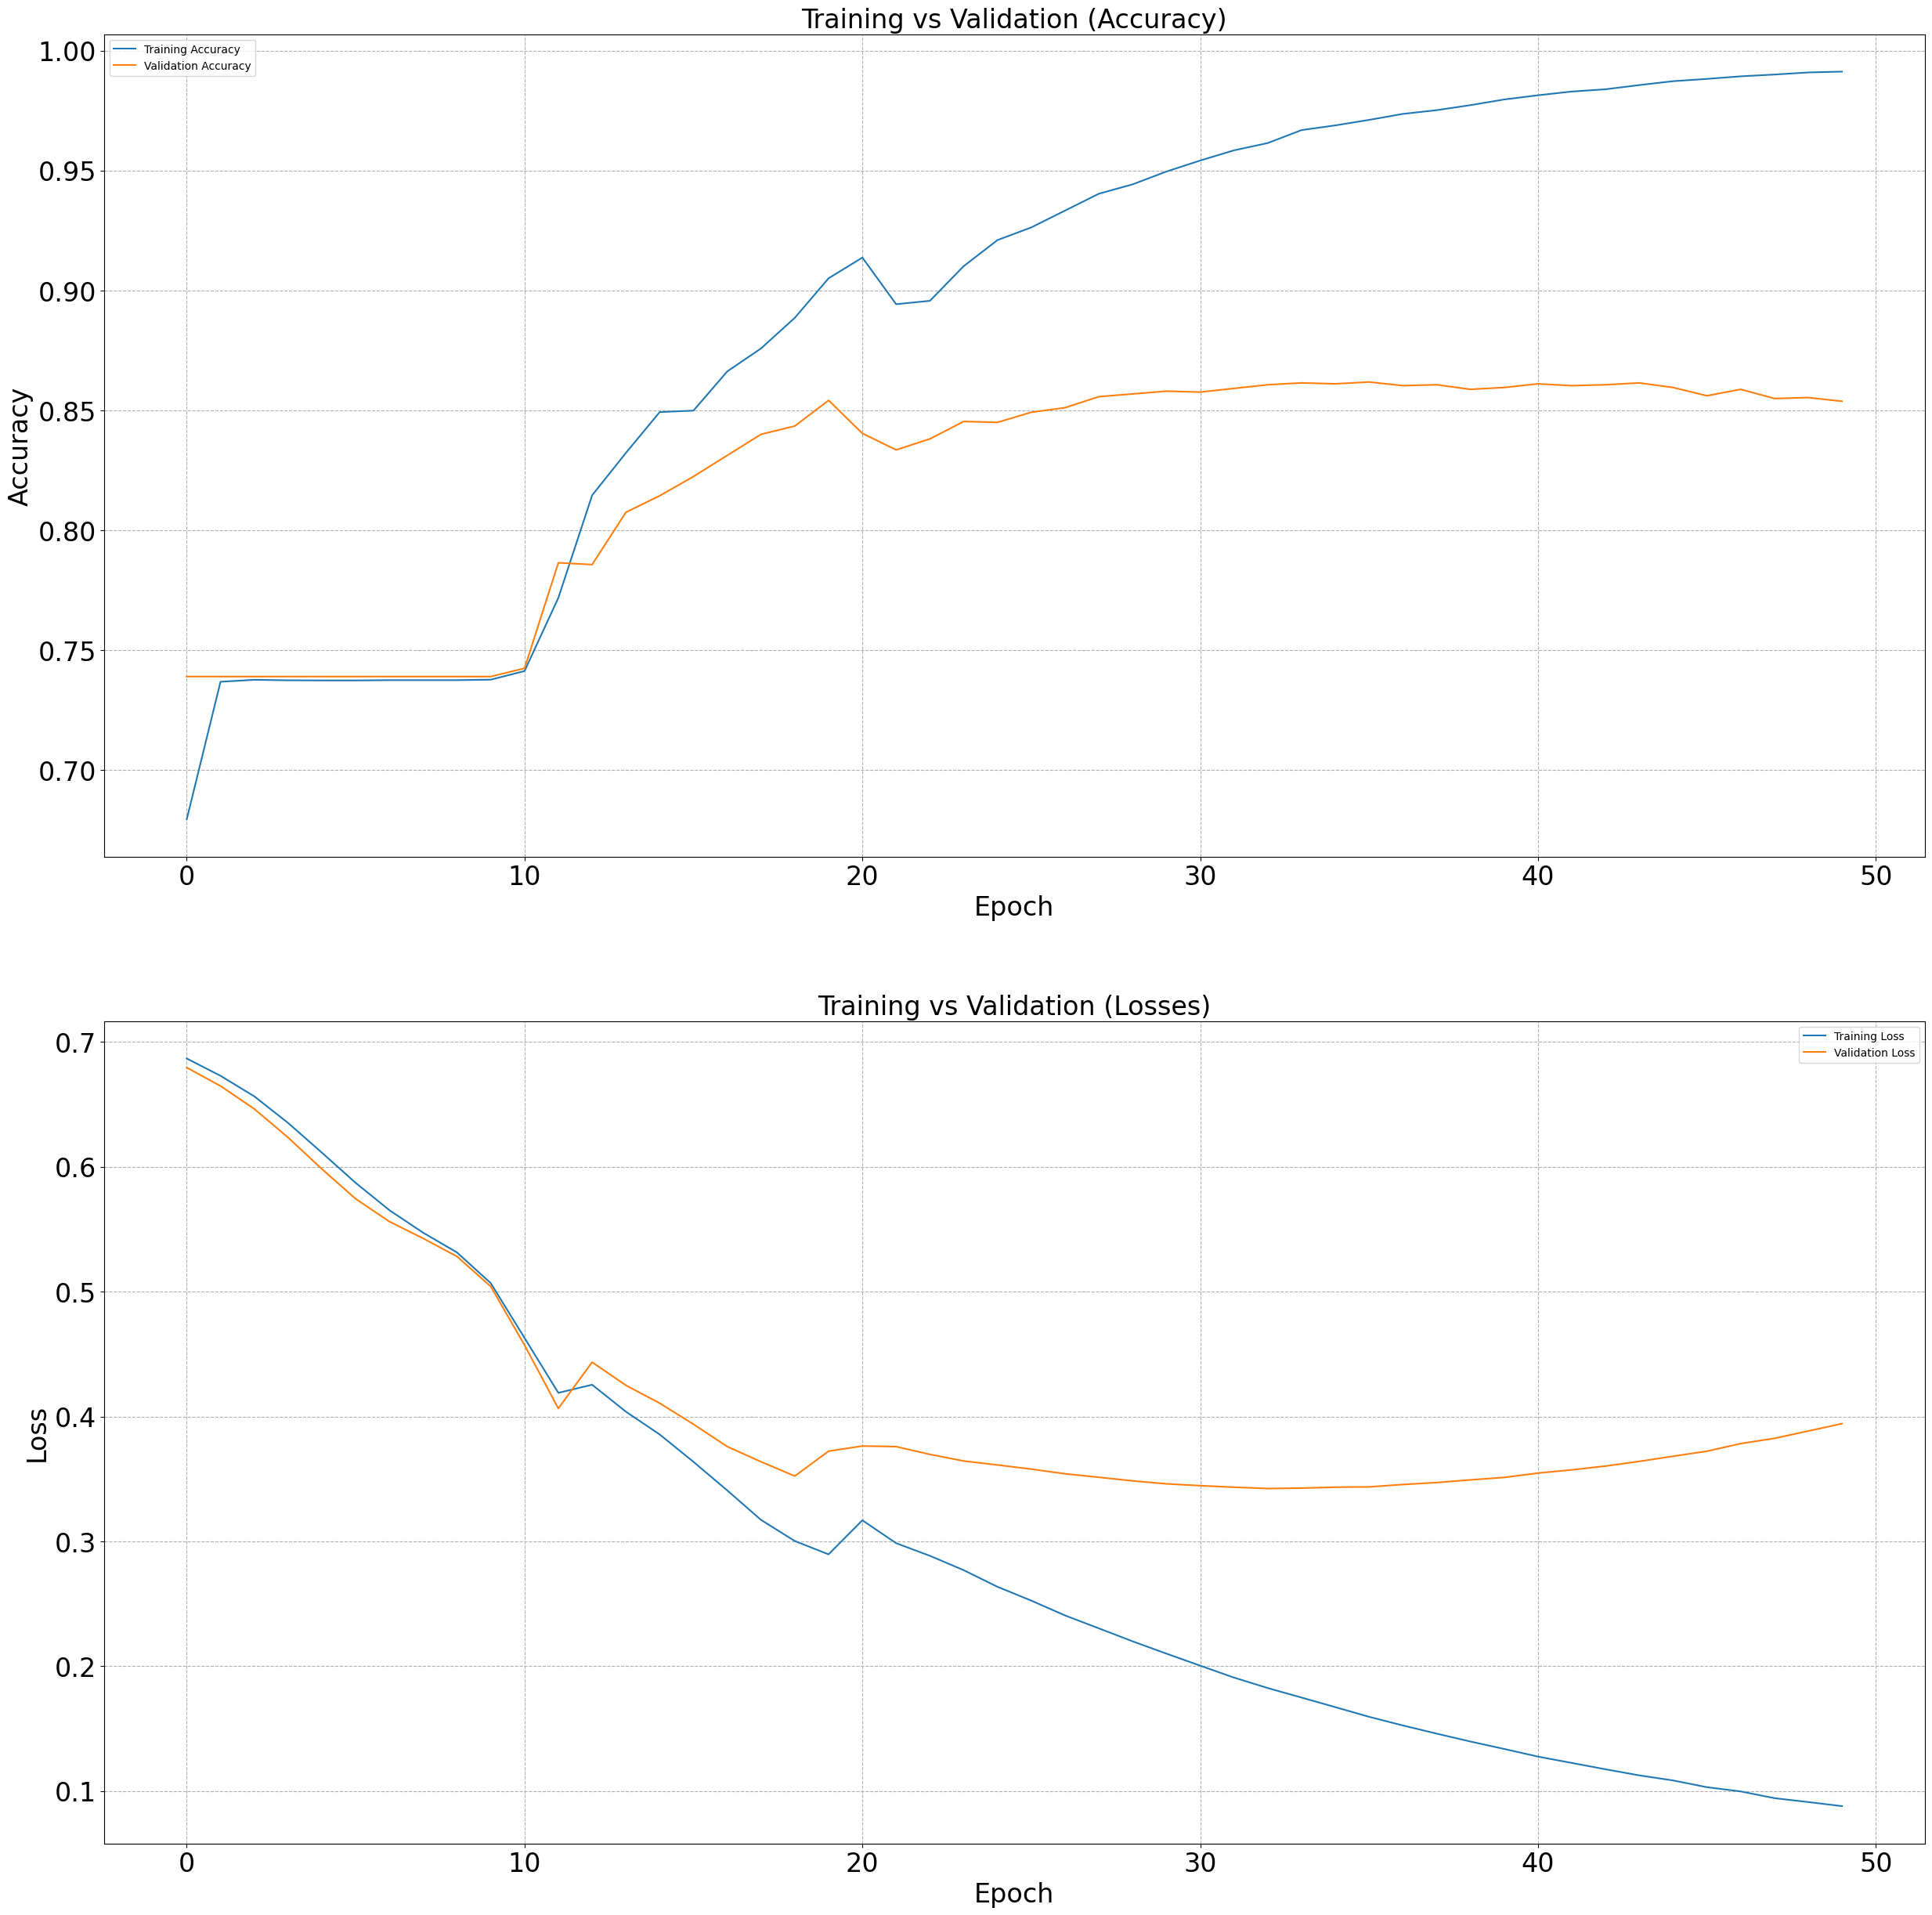

In [ ]:
# Training Data Evaluation
fig, ax = plt.subplots(2,1, figsize=(30,30))

# fig.suptitle('Training Data Evaluation', fontsize=50, weight='bold')

plt.subplot(2,1,1)
plt.title("Training vs Validation (Accuracy)", fontsize=24)
plt.plot(history2.history['accuracy'],label="Training Accuracy")
plt.plot(history2.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(2,1,2)
plt.title("Training vs Validation (Losses)", fontsize=24)
plt.plot(history2.history['loss'], label="Training Loss")
plt.plot(history2.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Loss", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

From the visualization above we can conclude that:


*   The model is still overfitting although we already do the improvement
*   Looks better compared to the baseline model
*   Accuracy of the model is a lot higher compared to baseline model



### Test Set

97/97 [==============================] - 6s 56ms/step
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       830
           1       0.89      0.88      0.88      2244

    accuracy                           0.83      3074
   macro avg       0.78      0.79      0.79      3074
weighted avg       0.83      0.83      0.83      3074



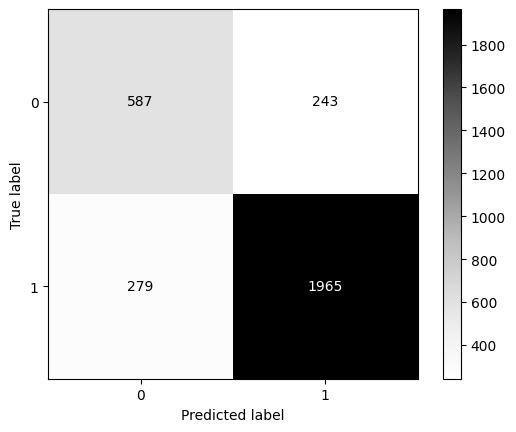

In [ ]:
# Model Evaluation of test-set

y_pred_2 = model_imp.predict(X_test)
y_pred_2 = np.where(y_pred_2 >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_2))

# confusion matrix

cm = confusion_matrix(y_test, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Greys')
plt.show()
     

We can see from the Clasification report above, the model has been improved a lot compared to base model. The accuracy is alot higher its about 83% on this model.

## 8.3 GRU Base Model


### Training Set


In [ ]:
# Create DataFrame

history3_df = pd.DataFrame(history3.history)
history3_df.tail(5)

,loss,accuracy,val_loss,val_accuracy
45,0.574540,0.737503,0.573215,0.738997
46,0.574513,0.737503,0.573197,0.738997
47,0.574488,0.737503,0.573179,0.738997
48,0.574462,0.737503,0.573161,0.738997
49,0.574435,0.737503,0.573143,0.738997


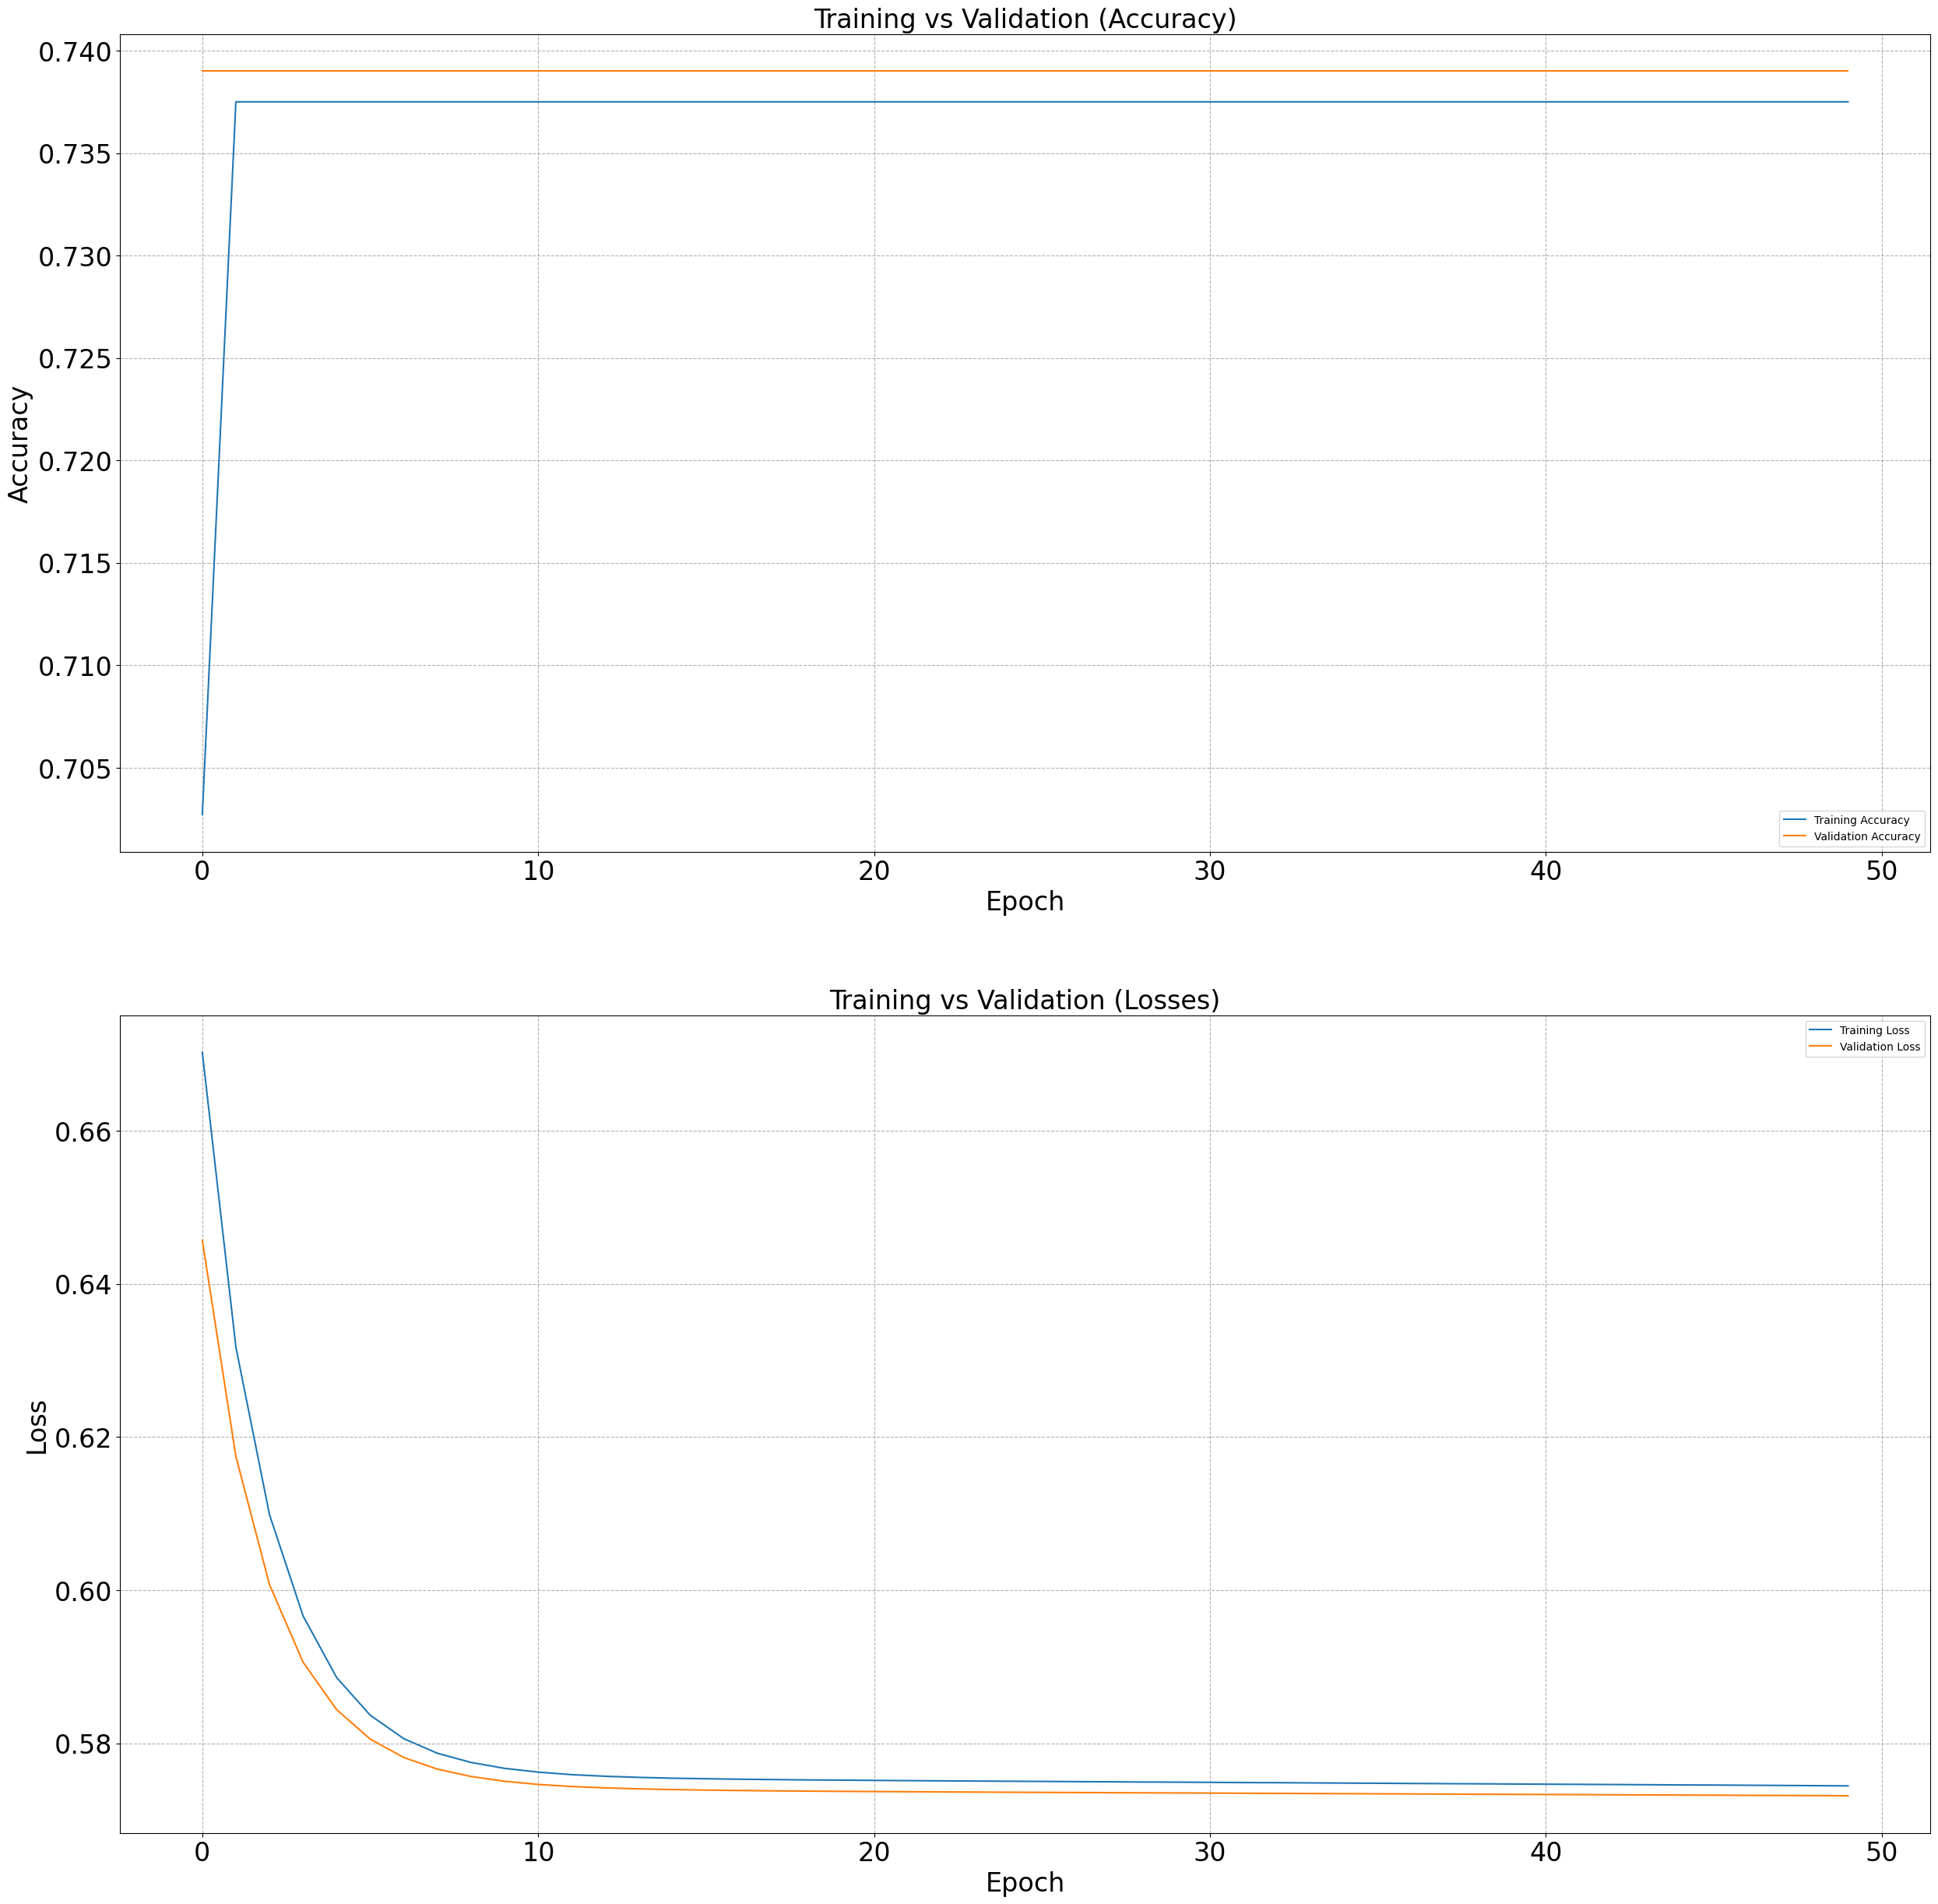

In [ ]:
# Training Data Evaluation
fig, ax = plt.subplots(2,1, figsize=(30,30))

# fig.suptitle('Training Data Evaluation', fontsize=50, weight='bold')

plt.subplot(2,1,1)
plt.title("Training vs Validation (Accuracy)", fontsize=24)
plt.plot(history3.history['accuracy'],label="Training Accuracy")
plt.plot(history3.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(2,1,2)
plt.title("Training vs Validation (Losses)", fontsize=24)
plt.plot(history3.history['loss'], label="Training Loss")
plt.plot(history3.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Loss", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

### Test Set

97/97 [==============================] - 6s 55ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       830
           1       0.73      1.00      0.84      2244

    accuracy                           0.73      3074
   macro avg       0.36      0.50      0.42      3074
weighted avg       0.53      0.73      0.62      3074



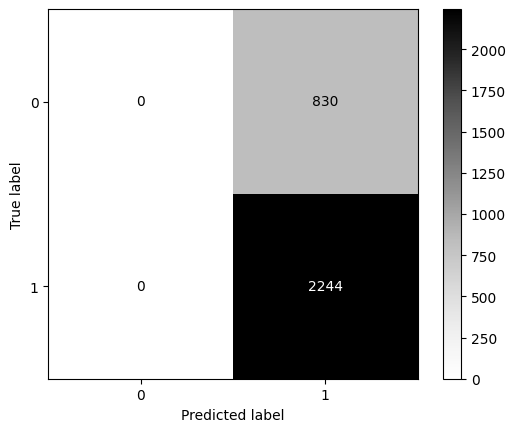

In [ ]:
# Model Evaluation of test-set

y_pred_3 = model_gru.predict(X_test)
y_pred_3 = np.where(y_pred_3 >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_3))

# confusion matrix

cm = confusion_matrix(y_test, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Greys')
plt.show()
     

It can be seen on the Classification report above, again on base model it shows that the model is not really good with the evaluation metrics really low, but we are gonna do some improvement from this baseline model.

## 8.4 GRU Improvement Model

### Training Set


In [ ]:
# Create DataFrame

history4_df = pd.DataFrame(history4.history)
history4_df.tail(5)

,loss,accuracy,val_loss,val_accuracy
45,0.088654,0.983315,0.420234,0.831994
46,0.082829,0.984193,0.425166,0.833525
47,0.079164,0.985342,0.429795,0.831611
48,0.074850,0.986963,0.434287,0.831611
49,0.071748,0.988922,0.439065,0.830846


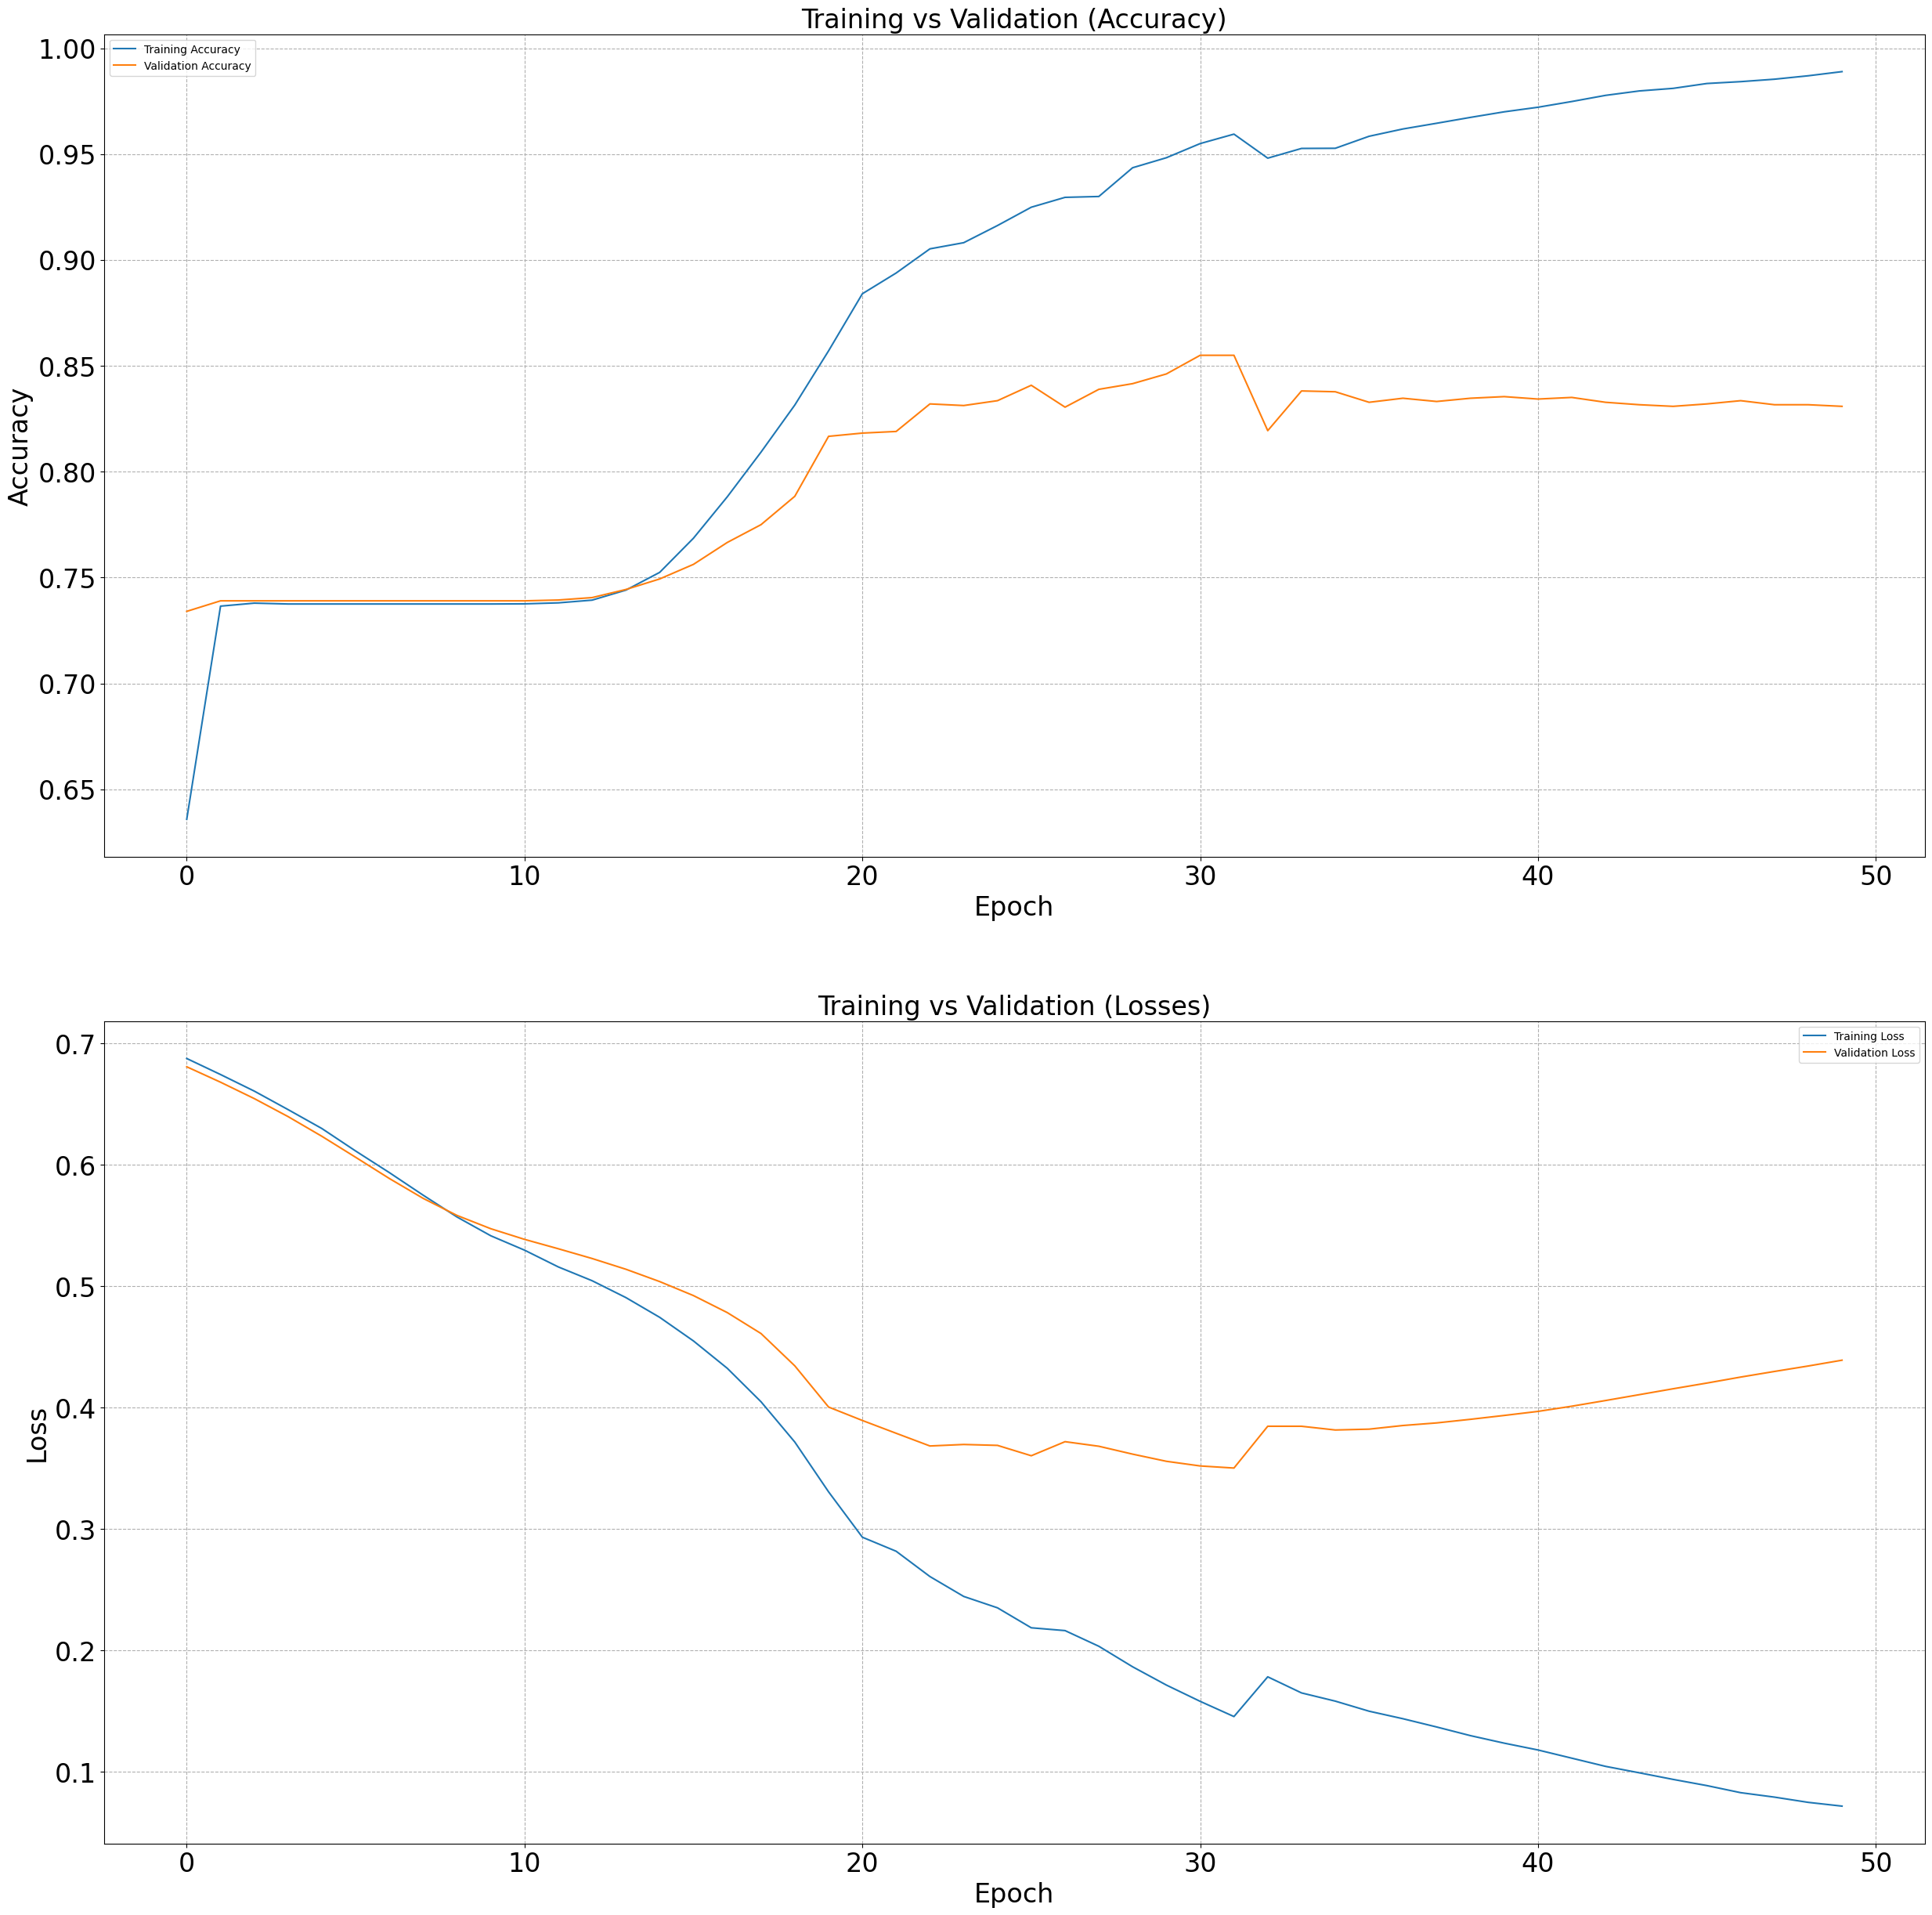

In [ ]:
# Training Data Evaluation
fig, ax = plt.subplots(2,1, figsize=(30,30))

# fig.suptitle('Training Data Evaluation', fontsize=50, weight='bold')

plt.subplot(2,1,1)
plt.title("Training vs Validation (Accuracy)", fontsize=24)
plt.plot(history4.history['accuracy'],label="Training Accuracy")
plt.plot(history4.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(2,1,2)
plt.title("Training vs Validation (Losses)", fontsize=24)
plt.plot(history4.history['loss'], label="Training Loss")
plt.plot(history4.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch", fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("Loss", fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

From the visualization above we can conclude that:


*   The model is still overfitting although we already do the improvement
*   Looks better compared to the baseline model
*   Accuracy of the model is a lot higher compared to baseline model

### Test Set

97/97 [==============================] - 6s 55ms/step
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       830
           1       0.87      0.88      0.88      2244

    accuracy                           0.82      3074
   macro avg       0.77      0.76      0.76      3074
weighted avg       0.81      0.82      0.81      3074



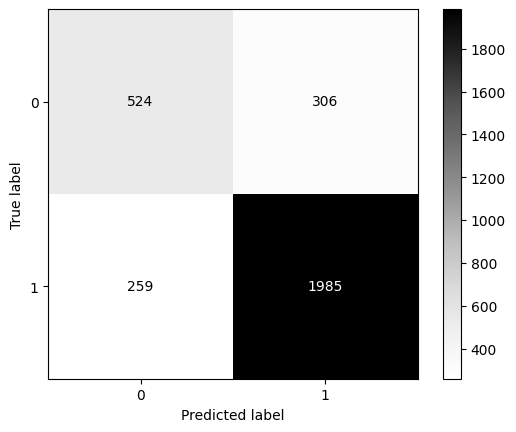

In [ ]:
# Model Evaluation of test-set

y_pred_4 = model_gruimp.predict(X_test)
y_pred_4 = np.where(y_pred_4 >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_4))

# confusion matrix

cm = confusion_matrix(y_test, y_pred_4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Greys')
plt.show()

We can see from the classification report compared to GRU base model the improved one is a lot better. On this improved model it got 81% on accuracy metric. 

## 8.5 Summary of Model Evaluation

According to all of the evaluation of 4 model that has been made. We are not gonna use any of the base model because of the evaluation score is really low. On the 2 improved model that we got, Improved LSTM has slightly better precision for class 0, while Improved GRU has slightly better precision for class 1. However, Improved LSTM has slightly better recall, f1-score, and accuracy overall.

According to the evaluation score, we're gonna choose the LSTM improved model as the model that we are gonna use, because it got slightly better accuracy score and accuracy is the metric that we are focusing on this modelling.

# ix. Model Saving

In [ ]:
# Creating data inference
df_inf = data.sample(10, random_state=0).sort_index()
print('size of data inference (rows,columns) : ',df_inf.shape)
df_inf.reset_index(drop=True).head(10)

size of data inference (rows,columns) :  (10, 2)


,Review,Rating
0,fabulous resort perfect hotel neice celebrate ...,5
1,ehhh better punta cana twice compared hotel st...,2
2,nice hotel great location great place stay cer...,4
3,"grand oasis wonderful second time, group 20 fr...",5
4,not bad stay stayed hotel family attending jav...,3
5,disappointing expected 4* hotel.we arrived tol...,3
6,great place stay heart paris fantastic stay re...,4
7,"4 n't think, decided book atenea night stay de...",2
8,awesome time just returned vacation fantastic ...,4
9,superb stayed ubud village resort 3 nights hon...,5


In [ ]:
# Saving data inference as .csv file
df_inf.to_csv('hh8dsft_P2M2_Satriya_Fauzan_Adhim_Inference.csv')

In [ ]:
# saving
with open('t.pickle', 'wb') as file_1:
    pickle.dump(t, file_1)

In [ ]:
# Summary of LSTM Improved Model
model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1835, 128)         6913920   
                                                                 
 bidirectional (Bidirectiona  (None, 1835, 64)         41216     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 8)                 2336      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,957,481
Trainable params: 6,957,481
Non-trainable params: 0
______________________________________________

In [ ]:
# Freeze Model
model_imp.trainable = False
model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1835, 128)         6913920   
                                                                 
 bidirectional (Bidirectiona  (None, 1835, 64)         41216     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 8)                 2336      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,957,481
Trainable params: 0
Non-trainable params: 6,957,481
______________________________________________

In [ ]:
# Save Model
model_imp.save('best_model.h5')

# x. Model Inference

Model Inference on another notebook.

# xi. Conclusion

EDA Conclusion:


1.   The distribution of data is imbalance, where the positive ratings is having a lot more data compared to  the negative ratings. Eventhough the positive one is higher, but the negative review is really important to be reviewed too.
2.   The key difference between positive and negative reviews is the attitude of the reviewer and their overall satisfaction with the hotel service where they stay. Positive reviews reflect a positive experience, while negative reviews reflect a negative experience.



Modelling Conclusion:

Based on the Model Analysis conducted, it is decided that the improved LSTM model is the best NLP modeling approach to predict sentiment of Trip Advisor Hotel review. The following findings are obtained regarding the model used:
1. With evaluation score of all accuracy 83% the models is good enough on the score, but if the model gonna be used on business it still need improvement so at least it can go up to 90% accuracy before it can be used. 
2.  Improved LSTM has slightly better precision for class 0, while Improved GRU has slightly better precision for class 1. However, Improved LSTM has slightly better recall, f1-score, and accuracy overall.


Business Insight:
1. From all of the review we can see the Sentiment analysis on Trip Advisor Hotel reviews can provide valuable insights for businesses, including identifying common issues that customers face with their products or services, understanding the factors that drive customer satisfaction, and tracking changes in customer sentiment over time.

For the modelling that has been made the modeling process can indeed be further improved, particularly in terms of hyperparameter tuning. Searching more optimal paramaters that can be used, potentially leading to better performance of the model.

Hyperparameter tuning is a crucial step in optimizing the model's performance. By systematically varying hyperparameters and evaluating the model's performance on validation data.

If more time can be put into hyperparameter tunings, its not impossible to get more accurate models that can predict Customer Churn better. 

We can improve this model from the data preprocessing too, such as reducing the vocabulary on the data, because from the re-scanning the data, there are words that still need preprocessing like words that appear in both reviews (adding words that appeared in both reviews into the stopwords), typo on the word on the review, broken word that doesn't mean anything, etc.

